In [4]:
import pandas as pd
import numpy as np

import gc
import time
import warnings

# stats
from scipy.misc import imread
from scipy import sparse
import scipy.stats as ss

# viz
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
import matplotlib_venn as venn

#nlp
import string
import re
import nltk
from nltk.corpus import stopwords
import spacy
from nltk import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.tokenize import TweetTokenizer

#FeatureEngineering
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_is_fitted
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

# settings
start_time = time.time()
color = sns.color_palette()
sns.set_style("dark")
eng_stopwords = set(stopwords.words("english"))
warnings.filterwarnings("ignore")

lem = WordNetLemmatizer()
tokenizer = TweetTokenizer()
%matplotlib inline

In [5]:
train = pd.read_csv("data/toxic/train.csv")
test = pd.read_csv("data/toxic/test.csv")
sample_submission = pd.read_csv("data/toxic/sample_submission.csv")

In [6]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [7]:
nrow_train=train.shape[0]
nrow_test=test.shape[0]
sum=nrow_train+nrow_test
print("       : train : test")
print("rows   :",nrow_train,":",nrow_test)
print("perc   :",round(nrow_train*100/sum),"   :",round(nrow_test*100/sum))

       : train : test
('rows   :', 159571, ':', 153164)
('perc   :', 51.0, '   :', 48.0)


In [8]:
x = train.iloc[:,2:].sum() #竖着对每一列求和结果
x

toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64

In [9]:
rowsums = train.iloc[:, 2:].sum(axis=1) # 横着对每一行求和
#这样统计所有的干净评论
train['clean'] = (rowsums<1) # rowsums == 0不对，浮点数和０比较出问题
train['clean'].sum()
print("Total comments = ",len(train))
print("Total clean comments = ",train['clean'].sum())
print("Total tags =",x.sum())

('Total comments = ', 159571)
('Total clean comments = ', 143346)
('Total tags =', 35098)


In [10]:
print("Check for missing values in Train dataset")
null_check=train.isnull().sum()
print(null_check)
print("Check for missing values in Test dataset")
null_check=test.isnull().sum()
print(null_check)
print("filling NA with \"unknown\"")
train["comment_text"].fillna("unknown", inplace=True)
test["comment_text"].fillna("unknown", inplace=True)

Check for missing values in Train dataset
id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
clean            0
dtype: int64
Check for missing values in Test dataset
id              0
comment_text    0
dtype: int64
filling NA with "unknown"


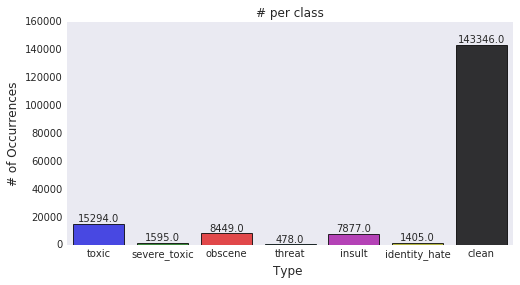

In [11]:
x=train.iloc[:,2:].sum()
#plot
plt.figure(figsize=(8,4))
ax= sns.barplot(x.index, x.values, alpha=0.8)
plt.title("# per class")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('Type ', fontsize=12)
#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

样本不是非常均衡，大部分多是干净评论

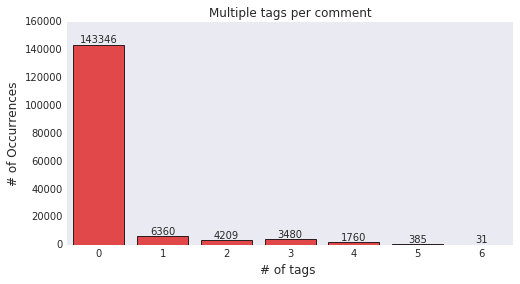

In [12]:
x=rowsums.value_counts()

#plot
plt.figure(figsize=(8,4))
ax = sns.barplot(x.index, x.values, alpha=0.8,color=color[2])
plt.title("Multiple tags per comment")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('# of tags ', fontsize=12)

#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

不同标签之间本身的相关性

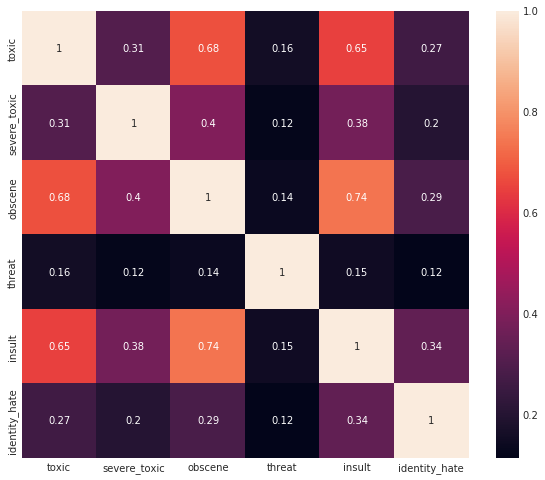

In [13]:
temp_df=train.iloc[:,2:-1]
# filter temp by removing clean comments
# temp_df=temp_df[~train.clean]

corr=temp_df.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, annot=True)

上面的相关系数是pandas默认使用的是皮尔逊相关系数，用在这里意义不大，因为这里涉及的变量都是分类的离散变量（二分的整数值）而不是连续变量。

- Confusion matrix/Crosstab
- Cramer's V Statistic
 * Cramer's V stat is an extension of the chi-square test where the extent/strength of association is also measured

参考[相关系数矩阵与热力图heatmap](https://blog.csdn.net/cymy001/article/details/79576019)

In [14]:
# https://pandas.pydata.org/pandas-docs/stable/style.html
def highlight_min(data, color='yellow'):
    '''
    highlight the maximum in a Series or DataFrame
    '''
    attr = 'background-color: {}'.format(color)
    if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
        is_min = data == data.min()
        return [attr if v else '' for v in is_min]
    else:  # from .apply(axis=None)
        is_max = data == data.min().min()
        return pd.DataFrame(np.where(is_min, attr, ''),
                            index=data.index, columns=data.columns)

In [15]:
#Crosstab
# Since technically a crosstab between all 6 classes is impossible to vizualize, lets take a 
# look at toxic with other tags
# Crosstab 类似于求笛卡尔积。交叉透视crosstab(a,b) b=[0,1,2,3] a=[A,B,C,D]
# 交叉完了之后就是A0,A1,A2,A3, B0,B1,B2,B3,C1,C2,C3,...类似excel交叉功能，
# 这里只能做成二维才能可视化，所以单独拿toxic 和其他所有的分开交叉,都是二维变量
main_col="toxic"
corr_mats=[]
for other_col in temp_df.columns[1:]:
    confusion_matrix = pd.crosstab(temp_df[main_col], temp_df[other_col])
    corr_mats.append(confusion_matrix)
out = pd.concat(corr_mats,axis=1,keys=temp_df.columns[1:])

#cell highlighting
out = out.style.apply(highlight_min,axis=0)
out

In [16]:
#https://stackoverflow.com/questions/20892799/using-pandas-calculate-cram%C3%A9rs-coefficient-matrix/39266194
def cramers_corrected_stat(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

In [17]:
#Checking for Toxic and Severe toxic for now
import pandas as pd
col1="toxic"
col2="severe_toxic"
confusion_matrix = pd.crosstab(temp_df[col1], temp_df[col2])
print("Confusion matrix between toxic and severe toxic:")
print(confusion_matrix)
new_corr=cramers_corrected_stat(confusion_matrix)
print("The correlation between Toxic and Severe toxic using Cramer's stat=",new_corr)

Confusion matrix between toxic and severe toxic:
severe_toxic       0     1
toxic                     
0             144277     0
1              13699  1595
("The correlation between Toxic and Severe toxic using Cramer's stat=", 0.3085120954599085)


# 词云

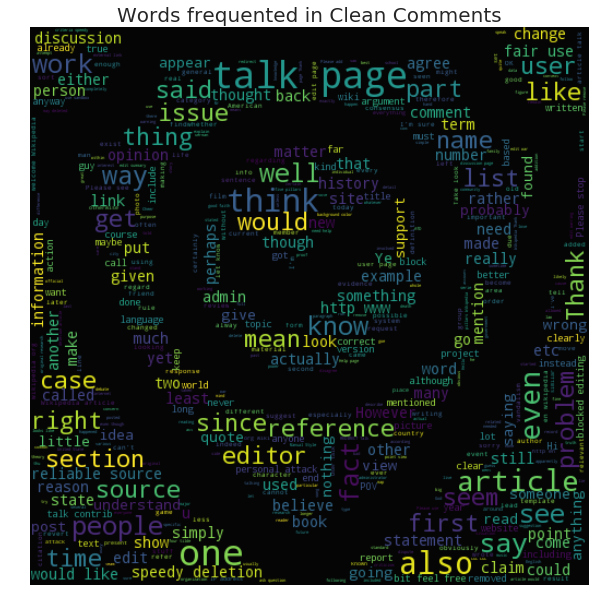

In [18]:
#clean comments
clean_mask=np.array(Image.open("./images/safe-zone.png"))
clean_mask=clean_mask[:,:,1]
#wordcloud for clean comments
subset=train[train.clean==True]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=2000,mask=clean_mask,stopwords=eng_stopwords)
wc.generate(" ".join(text))
plt.figure(figsize=(20,10))
plt.axis("off")
plt.title("Words frequented in Clean Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'viridis' , random_state=17), alpha=0.98)
plt.show()

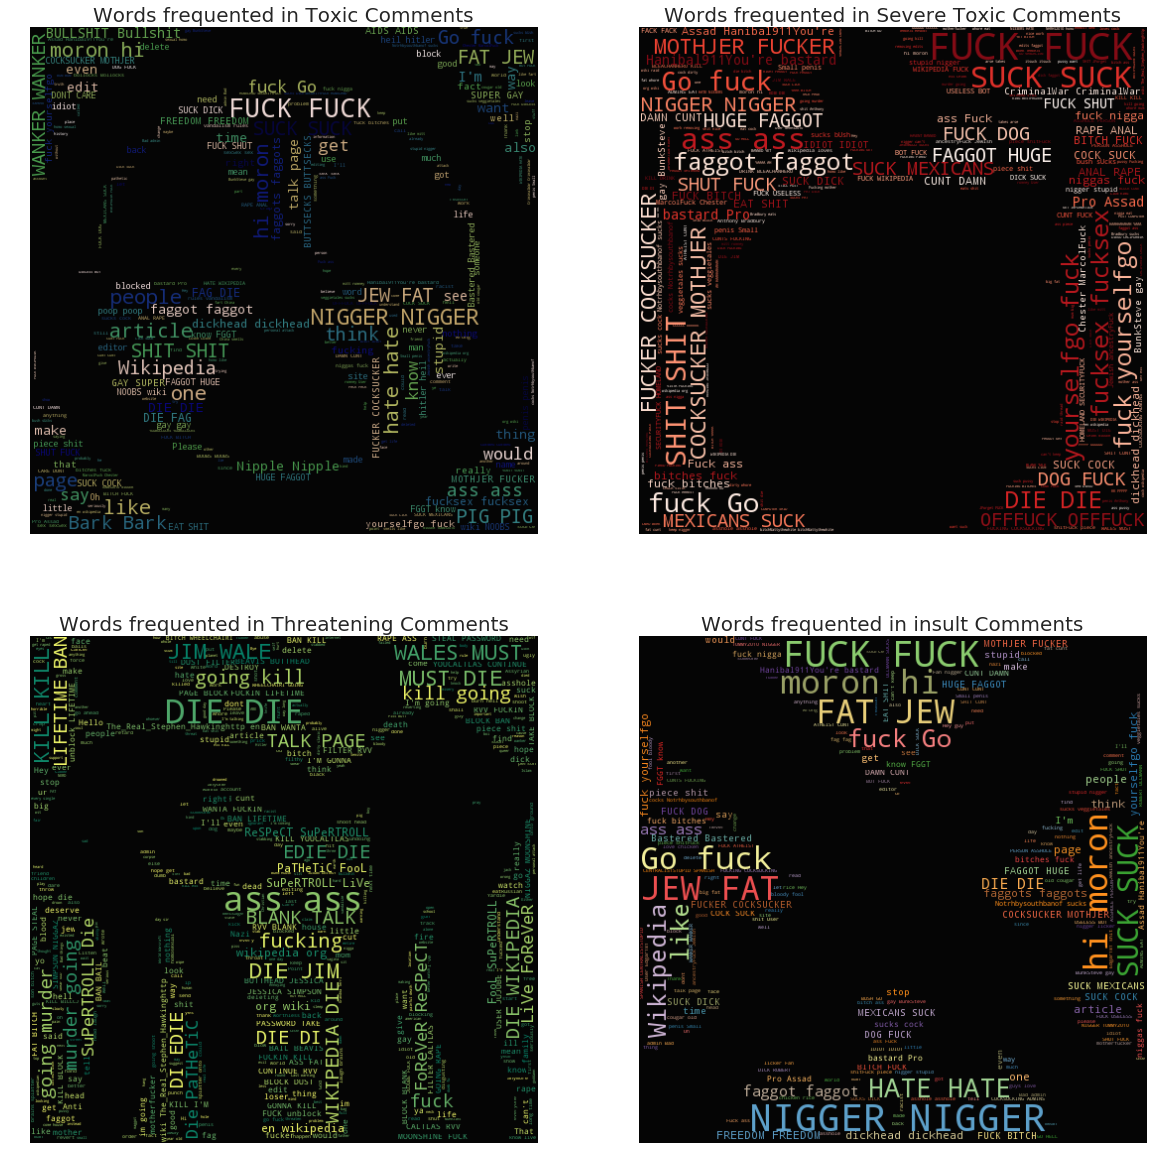

In [19]:
toxic_mask=np.array(Image.open("images/toxic-sign.png"))
toxic_mask=toxic_mask[:,:,1]
#wordcloud for clean comments
subset=train[train.toxic==1]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=4000,mask=toxic_mask,stopwords=eng_stopwords)
wc.generate(" ".join(text))
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.axis("off")
plt.title("Words frequented in Toxic Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'gist_earth' , random_state=244), alpha=0.98)

#Severely toxic comments
plt.subplot(222)
severe_toxic_mask=np.array(Image.open("images/bomb.png"))
severe_toxic_mask=severe_toxic_mask[:,:,1]
subset=train[train.severe_toxic==1]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=2000,mask=severe_toxic_mask,stopwords=eng_stopwords)
wc.generate(" ".join(text))
plt.axis("off")
plt.title("Words frequented in Severe Toxic Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'Reds' , random_state=244), alpha=0.98)

#Threat comments
plt.subplot(223)
threat_mask=np.array(Image.open("images/anger.png"))
threat_mask=threat_mask[:,:,1]
subset=train[train.threat==1]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=2000,mask=threat_mask,stopwords=eng_stopwords)
wc.generate(" ".join(text))
plt.axis("off")
plt.title("Words frequented in Threatening Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'summer' , random_state=2534), alpha=0.98)

#insult
plt.subplot(224)
insult_mask=np.array(Image.open("images/swords.png"))
insult_mask=insult_mask[:,:,1]
subset=train[train.insult==1]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=2000,mask=insult_mask,stopwords=eng_stopwords)
wc.generate(" ".join(text))
plt.axis("off")
plt.title("Words frequented in insult Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'Paired_r' , random_state=244), alpha=0.98)

plt.show()


# 特征工程
## 直接特征
　- word frequency/count
   - 词频
   - Bigrams
   - Trigrams
  - Word2ec
  - Sentiment Score
  
## 间接特征
 - count of sentences
 - count of words
 - count of unique words
 - count of letters
 - count of punctuations
 - count of uppercase words/letters
 - count of stop words
 - avg length of each word

## 隐私特征
因为在数据集中我们可以发现，有些用户的特定信息比如用户名字和IP地址，URL,文章ID等，恶毒评论往往带有同样的这种信息，我们可以提取这些信息，当然，这些信息也可能导致模型过拟合了。

## 注意
需要注意的是，一般在做特征提取的时候，先对未清理过的文本整体上提取间接特征和隐私特征，然后清理文本来提取直接特征
 - 直接特征的提取往往是从那些清洗之后的文本提取出来的(比如word2vec, 这些隐语义特征可能会去除标点符号，停用词等信息)
 - 间接特征往往可以用来补偿直接特征损失的信息

In [20]:
merge=pd.concat([train.iloc[:,0:2],test.iloc[:,0:2]])
df = merge.reset_index(drop=True)

In [21]:
## Indirect features

#Sentense count in each comment:
    #  '\n' can be used to count the number of sentences in each comment
df['count_sent']=df["comment_text"].apply(lambda x: len(re.findall("\n",str(x)))+1)
#Word count in each comment:
df['count_word']=df["comment_text"].apply(lambda x: len(str(x).split()))
#Unique word count
df['count_unique_word']=df["comment_text"].apply(lambda x: len(set(str(x).split())))
#Letter count
df['count_letters']=df["comment_text"].apply(lambda x: len(str(x)))
#punctuation count
df["count_punctuations"] =df["comment_text"].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
#upper case words count
df["count_words_upper"] = df["comment_text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
#title case words count
df["count_words_title"] = df["comment_text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
#Number of stopwords
df["count_stopwords"] = df["comment_text"].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))
#Average length of the words
df["mean_word_len"] = df["comment_text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

In [22]:
#derived features
#Word count percent in each comment:
df['word_unique_percent']=df['count_unique_word']*100/df['count_word']
#derived features
#Punct percent in each comment:
df['punct_percent']=df['count_punctuations']*100/df['count_word']

In [23]:
#serperate train and test features
train_feats=df.iloc[0:len(train),]
test_feats=df.iloc[len(train):,]
#join the tags
train_tags=train.iloc[:,2:]
train_feats=pd.concat([train_feats,train_tags],axis=1)

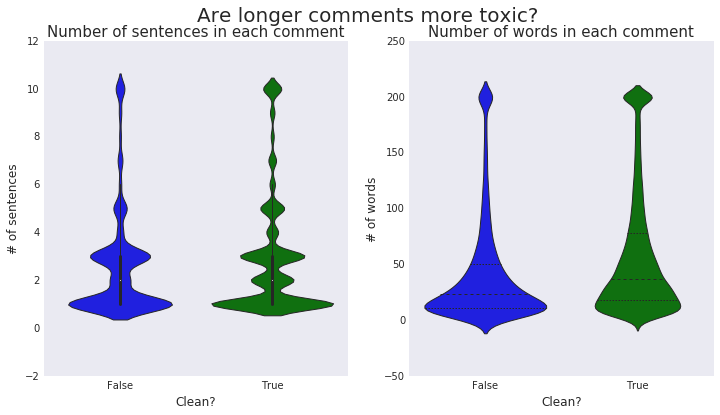

In [24]:
train_feats['count_sent'].loc[train_feats['count_sent']>10] = 10 
plt.figure(figsize=(12,6))
## sentenses
plt.subplot(121)
plt.suptitle("Are longer comments more toxic?",fontsize=20)
sns.violinplot(y='count_sent',x='clean', data=train_feats,split=True)
plt.xlabel('Clean?', fontsize=12)
plt.ylabel('# of sentences', fontsize=12)
plt.title("Number of sentences in each comment", fontsize=15)
# words
train_feats['count_word'].loc[train_feats['count_word']>200] = 200
plt.subplot(122)
sns.violinplot(y='count_word',x='clean', data=train_feats,split=True,inner="quart")
plt.xlabel('Clean?', fontsize=12)
plt.ylabel('# of words', fontsize=12)
plt.title("Number of words in each comment", fontsize=15)

plt.show()

密度估计放在一根对称轴的两边，然后竖起来就可以了。我们可以把它看做箱线图的同伴；箱线图只是展示了分位数的位置，小提琴图展示了任意位置的密度，通过小提琴图我们可以知道哪些位置的密度较高。中间的轴线对应的是百分位点。
从图上面来看的话，对于恶毒评论与否，和句子长度以及单词长度之间的关系没有明显差距。

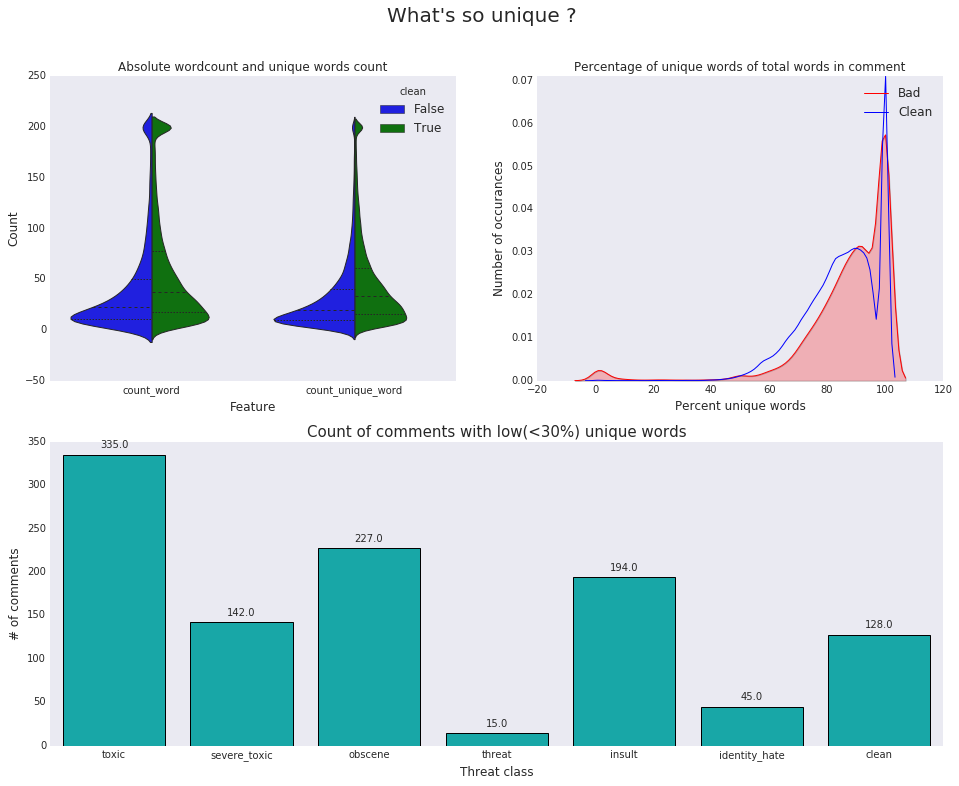

In [25]:
train_feats['count_unique_word'].loc[train_feats['count_unique_word']>200] = 200
#prep for split violin plots
#For the desired plots , the data must be in long format
temp_df = pd.melt(train_feats, value_vars=['count_word', 'count_unique_word'], id_vars='clean')
#spammers - comments with less than 40% unique words
spammers=train_feats[train_feats['word_unique_percent']<30]


plt.figure(figsize=(16,12))
plt.suptitle("What's so unique ?",fontsize=20)
gridspec.GridSpec(2,2)
plt.subplot2grid((2,2),(0,0))
sns.violinplot(x='variable', y='value', hue='clean', data=temp_df,split=True,inner='quartile')
plt.title("Absolute wordcount and unique words count")
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Count', fontsize=12)

plt.subplot2grid((2,2),(0,1))
plt.title("Percentage of unique words of total words in comment")
#sns.boxplot(x='clean', y='word_unique_percent', data=train_feats)
ax=sns.kdeplot(train_feats[train_feats.clean == 0].word_unique_percent, label="Bad",shade=True,color='r')
ax=sns.kdeplot(train_feats[train_feats.clean == 1].word_unique_percent, label="Clean")
plt.legend()
plt.ylabel('Number of occurances', fontsize=12)
plt.xlabel('Percent unique words', fontsize=12)

x=spammers.iloc[:,-7:].sum()
plt.subplot2grid((2,2),(1,0),colspan=2)
plt.title("Count of comments with low(<30%) unique words",fontsize=15)
ax=sns.barplot(x=x.index, y=x.values,color=color[3])

#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.xlabel('Threat class', fontsize=12)
plt.ylabel('# of comments', fontsize=12)
plt.show()

In [26]:
print("Clean Spam example:")
print(spammers[spammers.clean==1].comment_text.iloc[1])
print("Toxic Spam example:")
print(spammers[spammers.toxic==1].comment_text.iloc[2])

Clean Spam example:
Towns and Villages in Ark-La-Tex]]
 Cities, boroughs and towns in the Republic of Ireland
 Cities, boroughs, and townships along the Susquehanna River
 Cities, towns and villages in Alborz Province
 Cities, towns and villages in Ardabil Province
 Cities, towns and villages in Bhutan
 Cities, towns and villages in Bushehr Province
 Cities, towns and villages in Chaharmahal and Bakhtiari Province
 Cities, towns and villages in Cyprus
 Cities, towns and villages in Dutch Limburg
 Cities, towns and villages in East Azerbaijan Province
 Cities, towns and villages in East Timor
 Cities, towns and villages in Fars Province
 Cities, towns and villages in Flevoland
 Cities, towns and villages in Friesland
 Cities, towns and villages in Gelderland
 Cities, towns and villages in Gilan Province
 Cities, towns and villages in Golestan Province
 Cities, towns and villages in Groningen
 Cities, towns and villages in Hamadan Province
 Cities, towns and villages in Hormozgan Provinc

spam 垃圾广告信息往往也是恶毒信息

# 敏感信息( Leaky features)
需要注意的是敏感信息一般不会放在最终的机器学习模型中，但是对于最终的应用我们需要能够过滤出这些信息来来保证更好的效果。

In [27]:
#Leaky features
df['ip']=df["comment_text"].apply(lambda x: re.findall("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}",str(x)))
#count of ip addresses
df['count_ip']=df["ip"].apply(lambda x: len(x))

#links
df['link']=df["comment_text"].apply(lambda x: re.findall("http://.*com",str(x)))
#count of links
df['count_links']=df["link"].apply(lambda x: len(x))

#article ids
df['article_id']=df["comment_text"].apply(lambda x: re.findall("\d:\d\d\s{0,5}$",str(x)))
df['article_id_flag']=df.article_id.apply(lambda x: len(x))

#username
##              regex for     Match anything with [[User: ---------- ]]
# regexp = re.compile("\[\[User:(.*)\|")
df['username']=df["comment_text"].apply(lambda x: re.findall("\[\[User(.*)\|",str(x)))
#count of username mentions
df['count_usernames']=df["username"].apply(lambda x: len(x))
#check if features are created
#df.username[df.count_usernames>0]

# Leaky Ip
cv = CountVectorizer()
count_feats_ip = cv.fit_transform(df["ip"].apply(lambda x : str(x)))


# Leaky usernames

cv = CountVectorizer()
count_feats_user = cv.fit_transform(df["username"].apply(lambda x : str(x)))

In [28]:
df[df.count_usernames!=0].comment_text.iloc[0]

'2010]]\n[[User talk:Wikireader41/Archive4|Archive 5-Mar 15'

In [29]:
# check few names
cv.get_feature_names()[120:130]

[u'destruction',
 u'diablo',
 u'diligent',
 u'dland',
 u'dlohcierekim',
 u'dodo',
 u'dominick',
 u'douglas',
 u'dpl',
 u'dr']

sklearn.feature_extraction.text.CountVectorizer 其实就是拿到文档的TermFrequency矩阵,就是词汇表和文档两个维度的一个矩阵。

In [30]:
leaky_feats=df[["ip","link","article_id","username","count_ip","count_links","count_usernames","article_id_flag"]]
leaky_feats_train=leaky_feats.iloc[:train.shape[0]]
leaky_feats_test=leaky_feats.iloc[train.shape[0]:]

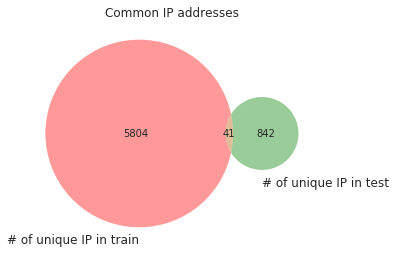

In [31]:
#filterout the entries without ips
train_ips=leaky_feats_train.ip[leaky_feats_train.count_ip!=0]
test_ips=leaky_feats_test.ip[leaky_feats_test.count_ip!=0]
#get the unique list of ips in test and train datasets
train_ip_list=list(set([a for b in train_ips.tolist() for a in b]))
test_ip_list=list(set([a for b in test_ips.tolist() for a in b]))

# get common elements
common_ip_list=list(set(train_ip_list).intersection(test_ip_list))
plt.title("Common IP addresses")
venn.venn2(subsets=(len(train_ip_list),len(test_ip_list),len(common_ip_list)),set_labels=("# of unique IP in train","# of unique IP in test"))
plt.show()

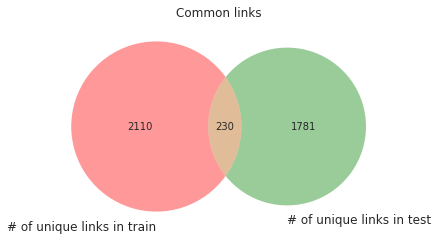

In [32]:
#filterout the entries without links
train_links=leaky_feats_train.link[leaky_feats_train.count_links!=0]
test_links=leaky_feats_test.link[leaky_feats_test.count_links!=0]
#get the unique list of ips in test and train datasets
train_links_list=list(set([a for b in train_links.tolist() for a in b]))
test_links_list=list(set([a for b in test_links.tolist() for a in b]))

# get common elements
common_links_list=list(set(train_links_list).intersection(test_links_list))
plt.title("Common links")
venn.venn2(subsets=(len(train_links_list),len(test_links_list),len(common_links_list)),
           set_labels=("# of unique links in train","# of unique links in test"))
plt.show()

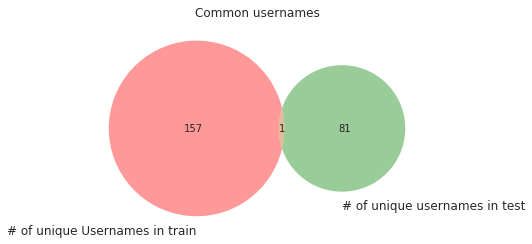

In [33]:

#filterout the entries without users
train_users=leaky_feats_train.username[leaky_feats_train.count_usernames!=0]
test_users=leaky_feats_test.username[leaky_feats_test.count_usernames!=0]
#get the unique list of ips in test and train datasets
train_users_list=list(set([a for b in train_users.tolist() for a in b]))
test_users_list=list(set([a for b in test_users.tolist() for a in b]))

# get common elements
common_users_list=list(set(train_users_list).intersection(test_users_list))
plt.title("Common usernames")
venn.venn2(subsets=(len(train_users_list),len(test_users_list),len(common_users_list)),
           set_labels=("# of unique Usernames in train","# of unique usernames in test"))
plt.show()

# 文本清洗(Cropus clean)


In [34]:
corpus = merge.comment_text

In [35]:
#https://drive.google.com/file/d/0B1yuv8YaUVlZZ1RzMFJmc1ZsQmM/view
# Aphost lookup dict
APPO = {
"aren't" : "are not",
"can't" : "cannot",
"couldn't" : "could not",
"didn't" : "did not",
"doesn't" : "does not",
"don't" : "do not",
"hadn't" : "had not",
"hasn't" : "has not",
"haven't" : "have not",
"he'd" : "he would",
"he'll" : "he will",
"he's" : "he is",
"i'd" : "I would",
"i'd" : "I had",
"i'll" : "I will",
"i'm" : "I am",
"isn't" : "is not",
"it's" : "it is",
"it'll":"it will",
"i've" : "I have",
"let's" : "let us",
"mightn't" : "might not",
"mustn't" : "must not",
"shan't" : "shall not",
"she'd" : "she would",
"she'll" : "she will",
"she's" : "she is",
"shouldn't" : "should not",
"that's" : "that is",
"there's" : "there is",
"they'd" : "they would",
"they'll" : "they will",
"they're" : "they are",
"they've" : "they have",
"we'd" : "we would",
"we're" : "we are",
"weren't" : "were not",
"we've" : "we have",
"what'll" : "what will",
"what're" : "what are",
"what's" : "what is",
"what've" : "what have",
"where's" : "where is",
"who'd" : "who would",
"who'll" : "who will",
"who're" : "who are",
"who's" : "who is",
"who've" : "who have",
"won't" : "will not",
"wouldn't" : "would not",
"you'd" : "you would",
"you'll" : "you will",
"you're" : "you are",
"you've" : "you have",
"'re": " are",
"wasn't": "was not",
"we'll":" will",
"didn't": "did not",
"tryin'":"trying"
}

In [36]:
def clean(comment):
    """
    This function receives comments and returns clean word-list
    """
    #Convert to lower case , so that Hi and hi are the same
    comment=comment.lower()
    #remove \n
    comment=re.sub("\\n","",comment)
    # remove leaky elements like ip,user
    comment=re.sub("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}","",comment)
    #removing usernames
    comment=re.sub("\[\[.*\]","",comment)
    
    #Split the sentences into words
    words=tokenizer.tokenize(comment)
    
    # (')aphostophe  replacement (ie)   you're --> you are  
    # ( basic dictionary lookup : master dictionary present in a hidden block of code)
    words=[APPO[word] if word in APPO else word for word in words]
    words=[lem.lemmatize(word, "v") for word in words]
    words = [w for w in words if not w in eng_stopwords]
    
    clean_sent=" ".join(words)
    # remove any non alphanum,digit character
    #clean_sent=re.sub("\W+"," ",clean_sent)
    #clean_sent=re.sub("  "," ",clean_sent)
    return(clean_sent)

In [37]:
corpus.iloc[12235]

'"\n\n NOTE If you read above, and follow the links, any reader can see that I cited correctly the links I added on this subject. Vidkun has added anotations to make them read as the oposite, but these links show the ""official"" line taken by UGLE. I will not be trapped by any User into so-called 3RR, so he can peddle his POV. Strangly, ALL other ""MASONS"" are quiet, leaving \xe2\x80\x98\xe2\x80\x98me\xe2\x80\x99\xe2\x80\x99 to defend that factual truth on my own. ""Thanks"" Brethren. Sitting any blocking out if given...  "'

In [38]:
clean(corpus.iloc[12235])

u'" note read , follow link , reader see cite correctly link add subject . vidkun add anotations make read oposite , link show " " official " " line take ugle . trap user so-called 3rr , peddle pov . strangly , " " masons " " quiet , leave \u2018 \u2018 \u2019 \u2019 defend factual truth . " " thank " " brethren . sit block give ... "'

In [39]:
clean_corpus=corpus.apply(lambda x :clean(x))

end_time=time.time()
print("total time till Cleaning",end_time-start_time)

('total time till Cleaning', 248.47929191589355)


# 直接特征
## 1 Count based features(for unigrams)
`sklearn.feature_extraction.text` 中的　`TfidfVectorizer, CountVectorizer, HashingVectorizer`; 我们所熟悉的bag-of-words模型，TF-IDF 模型以及大量文本的Hashing模型。
 - CountVectorizer
  * Creates a matrix with frequency counts of each word in the text corpus
 - TF-IDF Vectorizer
  * TF - Term Frequency -- Count of the words(Terms) in the text corpus (same of Count Vect)
  * IDF - Inverse Document Frequency -- Penalizes words that are too frequent. We can think of this as regularization
 - HashingVectorizer
  * Creates a hashmap(word to number mapping based on hashing technique) instead of a dictionary for vocabulary
  * This enables it to be more scalable and faster for larger text coprus
  * Can be parallelized across multiple threads


In [40]:
### Unigrams -- TF-IDF 
# using settings recommended here for TF-IDF -- https://www.kaggle.com/abhishek/approaching-almost-any-nlp-problem-on-kaggle

#some detailed description of the parameters
# min_df=10 --- ignore terms that appear lesser than 10 times 
# max_features=None  --- Create as many words as present in the text corpus
    # changing max_features to 10k for memmory issues
# analyzer='word'  --- Create features from words (alternatively char can also be used)
# ngram_range=(1,1)  --- Use only one word at a time (unigrams)
# strip_accents='unicode' -- removes accents
# use_idf=1,smooth_idf=1 --- enable IDF
# sublinear_tf=1   --- Apply sublinear tf scaling, i.e. replace tf with 1 + log(tf)


#temp settings to min=200 to facilitate top features section to run in kernals
#change back to min=10 to get better results
start_unigrams=time.time()
tfv = TfidfVectorizer(min_df=200,  max_features=10000, 
            strip_accents='unicode', analyzer='word',ngram_range=(1,1),
            use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')
tfv.fit(clean_corpus)
features = np.array(tfv.get_feature_names())

train_unigrams =  tfv.transform(clean_corpus.iloc[:train.shape[0]])
test_unigrams = tfv.transform(clean_corpus.iloc[train.shape[0]:])

In [41]:
#https://buhrmann.github.io/tfidf-analysis.html
def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

def top_feats_in_doc(Xtr, features, row_id, top_n=25):
    ''' Top tfidf features in specific document (matrix row) '''
    row = np.squeeze(Xtr[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)

def top_mean_feats(Xtr, features, grp_ids, min_tfidf=0.1, top_n=25):
    ''' Return the top n features that on average are most important amongst documents in rows
        indentified by indices in grp_ids. '''
    
    D = Xtr[grp_ids].toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)

# modified for multilabel milticlass
def top_feats_by_class(Xtr, features, min_tfidf=0.1, top_n=20):
    ''' Return a list of dfs, where each df holds top_n features and their mean tfidf value
        calculated across documents with the same class label. '''
    dfs = []
    cols=train_tags.columns
    for col in cols:
        ids = train_tags.index[train_tags[col]==1]
        feats_df = top_mean_feats(Xtr, features, ids, min_tfidf=min_tfidf, top_n=top_n)
        feats_df.label = label
        dfs.append(feats_df)
    return dfs

In [42]:
#get top n for unigrams
tfidf_top_n_per_lass=top_feats_by_class(train_unigrams,features)

end_unigrams=time.time()

print("total time in unigrams",end_unigrams-start_unigrams)
print("total time till unigrams",end_unigrams-start_time)

('total time in unigrams', 730.706799030304)
('total time till unigrams', 979.1947829723358)
